<a href="https://colab.research.google.com/github/AvivGelfand/Fine-tuning-Large-Language-Models/blob/main/Improved_DistilBERT_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connecting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Installing and Importing Libraries

|Label|Accuracy|Auc-R|F1|Precision|Recall|Support|TP|FP|TN|FN|
|---|---|---|---|---|---|---|---|---|---|---|
|BAD\_RECORD|0\.996129|0\.960232|0\.645161|0\.8|0\.540541|27|20|5|5642|17|
|CIRCUMSTANCE|0\.901148|0\.900312|0\.900312|0\.909717|0\.909037|3342|3038|299|2459|304|
|FAMILY|0\.986721|0\.859972|0\.729097|0\.731544|0\.726667|150|109|40|5910|41|
|FINANCIAL|0\.952787|0\.887953|0\.796897|0\.79021|0\.803698|703|565|150|5247|138|
|GOOD\_RECORD|0\.973115|0\.973546|0\.951364|0\.929316|0\.974484|1646|1604|122|4332|42|
|INNOCENCE|0\.956557.|0\.769102|0\.605067|0\.663399|0\.556164|365|203|103|5632|162|
|LICENSE|0\.981639|0\.804642|0\.670588|0\.735484|0\.616216|185|114|41|5874|71|
|MEDICAL|0\.990328|0\.744197|0\.528|0\.568966|0\.492537|67|33|25|6008|34|
|OFFICER|0\.987049|0\.930597|0\.755418|0\.66667|0\.871429|140|122|61|5899|18|
|OUT\_STATE|0\.989344|0\.838678|0\.68599|0\.68932|0\.682692|104|71|32|5964|33|
|REMORSE|0\.920656|0\.885683|0\.806864|0\.787383|0\.827332|1222|1011|273|4605|211|

In [ ]:
%pip install -q transformers datasets pyTelegramBotAPI accelerate optuna optuna-integration  #peft bitsandbytes #sacremoses # %pip install setfit


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import torch
# from datasets import load_dataset, Dataset
from transformers import Trainer,TrainingArguments, EarlyStoppingCallback,TrainerCallback,TrainerState,TrainerControl
# from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification
# from transformers import LlamaForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding
from google.colab import userdata
import telebot
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import precision_recall_curve,roc_auc_score
from transformers import DistilBertConfig, DistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments,EarlyStoppingCallback,TrainingArguments,Trainer
from torch.utils.data import Dataset
import io
import os

# Inference funcs

In [ ]:
# @title
def predict_probabilities(trainer, dataset):
  pred_dict = trainer.predict(dataset)
  logits = pred_dict[0] # Use your actual logits here
  probabilities = 1 / (1 + np.exp(-logits)) # Convert logits to probabilities using the sigmoid function
  probabilities = probabilities.flatten() # Flatten arrays for compatibility with sklearn.metrics function
  label_ids = np.array(pred_dict[1])
  label_ids = label_ids.flatten()
  return label_ids, probabilities
  # df[f'{col}_prob'] = probabilities
  # bot = telebot.TeleBot(bot_id)
  # message_text = f"Master Bruce, col train prediction is finneshed"
  # bot.send_message(chat_id,message_text);
def plot_curves(label_ids, probabilities, col, set_name):
    precision, recall, thresholds = precision_recall_curve(label_ids, probabilities)
    thresholds = np.append(thresholds, 1)  # Append 1 to thresholds for completeness

    # Ensure probabilities is a numpy array
    probabilities_np = np.array(probabilities)  # Convert if `probabilities` is not already a numpy array

    # Then, you can safely use operations like the following
    # Vectorized prediction calculation
    predictions = probabilities_np[:, None] >= thresholds[None, :]
    # predictions = probabilities[:, None] >= thresholds[None, :]


    # Ensure label_ids is a boolean array and compatible for broadcasting
    label_ids_bool = np.array(label_ids, dtype=bool)[:, None]
    # Corrected bitwise operations
    # Vectorized computation for true positives, false positives, false negatives, and true negatives
    # These are conceptual; actual implementation might differ based on the desired metrics
    tp = (predictions & label_ids_bool).sum(axis=0)
    fp = (predictions & ~label_ids_bool).sum(axis=0)
    fn = (~predictions & label_ids_bool).sum(axis=0)
    tn = (~predictions & ~label_ids_bool).sum(axis=0)

    # Calculate metrics based on the confusion matrix components
    f1_scores = 2 * tp / (2 * tp + fp + fn)
    accuracy_scores = (tp + tn) / (tp + fp + fn + tn)

    # Plotting (remains unchanged)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=thresholds, y=precision[:-1], mode='lines', name='Precision'))
    fig.add_trace(go.Scatter(x=thresholds, y=recall[:-1], mode='lines', name='Recall'))
    fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1'))
    fig.add_trace(go.Scatter(x=thresholds, y=accuracy_scores, mode='lines', name='Accuracy'))
    fig.update_layout(title=f'{col} {set_name} Set - Metric vs. Threshold Curves', xaxis_title='Threshold', yaxis_title='Metric Value', yaxis=dict(range=[0, 1]), width=800, height=600, hovermode='x unified')
    fig.show()
    # fig = go.Figure()# confusion matrix Threshold curve
    # fig.add_trace(go.Scatter(x=thresholds, y=tps_ls, mode='lines', name='TP'))
    # fig.add_trace(go.Scatter(x=thresholds, y=fps_ls, mode='lines', name='FP'))
    # fig.add_trace(go.Scatter(x=thresholds, y=fns_ls, mode='lines', name='FN'))
    # fig.add_trace(go.Scatter(x=thresholds, y=tns_ls, mode='lines', name='TN'))
    # # Updating layout with unified hover mode
    # fig.update_layout(title=f'{col} {set_name} Set - Confusion Matrix Curves',xaxis_title='Threshold',yaxis_title='Metric Value',yaxis=dict(range=[0, 6000]),width=800,height=600,hovermode='x unified')
    # fig.show();

import numpy as np
def cm_plot(final_threshold,probabilities,label_ids,col,set_name):

  # Apply threshold to convert probabilities to binary predictions
  predictions = (probabilities > final_threshold).astype(int)
  cm_temp = confusion_matrix(label_ids, predictions)
  met_dic_test = {'Accuracy': accuracy_score(label_ids, predictions),'Roc_Auc': roc_auc_score(label_ids, predictions),
                  'F1_score': f1_score(label_ids, predictions),'Precision': precision_score(label_ids, predictions,),
                  'Recall': recall_score(label_ids, predictions),'Support': cm_temp[1][0] + cm_temp[1][1],
                  'TP' : cm_temp[1][1],'FP' : cm_temp[0][1],'TN' : cm_temp[0][0],'FN' : cm_temp[1][0]}
  metrics_df = pd.DataFrame([met_dic_test])
  display(metrics_df)
  fig, ax = plt.subplots(figsize=(7, 7))
  sns.heatmap(cm_temp, annot=True,  annot_kws={"size": 18} ,fmt="d", cmap="Wistia", ax=ax,cbar=False)
  ax.set_xlabel("Predicted Values", fontsize=19)
  ax.set_ylabel("Actual Values", fontsize=19)
  ax.set_title(f"{col} - {set_name}"# - Confusion Matrix"
               , fontsize=20)
  message_text = f"{col} - {set_name} - final_threshold: {final_threshold}" +f" {col} {set_name} metrics: {str(met_dic_test)}"
  bot.send_message(chat_id,message_text);
  # Save the plot to an in-memory file
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  buf.seek(0)  # Go to the start of the IO stream
  bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
  plt.show();


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import io  # Make sure to import necessary modules like io if not already done

def func(final_threshold, probabilities, label_ids, col, set_name):
    # Apply threshold to convert probabilities to binary predictions
    predictions = (probabilities > final_threshold).astype(int)
    cm_temp = confusion_matrix(label_ids, predictions)
    met_dic_test = {
        'Accuracy': accuracy_score(label_ids, predictions),
        'Roc_Auc': roc_auc_score(label_ids, predictions),
        'F1_score': f1_score(label_ids, predictions),
        'Precision': precision_score(label_ids, predictions),
        'Recall': recall_score(label_ids, predictions),
        'Support': cm_temp[1][0] + cm_temp[1][1],
        'TP': cm_temp[1][1],
        'FP': cm_temp[0][1],
        'TN': cm_temp[0][0],
        'FN': cm_temp[1][0]
    }
    metrics_df = pd.DataFrame([met_dic_test])
    display(metrics_df)

    # Increase figure size for better visibility
    fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figure size as needed

    # Customize heatmap
    sns.heatmap(cm_temp, annot=True, annot_kws={"size": 24, "weight": "bold"}, fmt="d", cmap="Wistia", ax=ax, cbar=False)  # Increase annot size for bigger text

    # Enhance font size and make them bold
    # Set tick labels for x and y axes
    ax.set_xlabel("Predicted Values", fontsize=24,)# fontweight='bold')
    ax.set_ylabel("Actual Values", fontsize=24,)# fontweight='bold')
    ax.set_title(f"{col} - {set_name}"# - Confusion Matrix"
                 , fontsize=25, fontweight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20,
                      #  fontweight='bold',
                       rotation=45)  # Rotate x-axis labels
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20,
                      #  fontweight='bold',
                       rotation=45)  # Rotate y-axis labels as well

    # Formatting message text to send
    message_text = f"{col} - {set_name} - final_threshold: {final_threshold}" + f" {col} {set_name} metrics: {str(met_dic_test)}"
    bot.send_message(chat_id, message_text)

    # Save the plot to an in-memory file
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')  # Ensure the entire plot is saved
    buf.seek(0)  # Go to the start of the IO stream
    bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID



def plot_confusion_matrices_v2(csv_file):
    # Load the data
    data = pd.read_csv(csv_file)

    # Determine the number of rows (and thus the number of plots)
    num_plots = data.shape[0]

    # Calculate the number of rows and columns for the subplot grid
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    # Create the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    axes = axes.flatten()  # Flatten to simplify indexing

    # Plot the confusion matrices for each data row
    for i, row in data.iterrows():
        matrix = np.array([[ row['TN'],  row['FP']], [row['FN'],row['TP'],]])
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Wistia", annot_kws={"size": 20}, ax=axes[i], cbar=False)
        axes[i].set_title(row['Label'],fontsize=20,fontweight='bold')
        axes[i].set_xlabel('Predicted',fontsize=18)
        axes[i].set_ylabel('Actual',fontsize=18)
        axes[i].set_xticklabels(axes[i].get_xticklabels(),fontsize=18, rotation=45)
        axes[i].set_yticklabels(axes[i].get_yticklabels(),fontsize=18, rotation=45)
        axes[i]

    # For any remaining axes, make them invisible
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    # plt.subplots_adjust(hspace=0.55,wspace=0.5)  # Increase the vertical space between rows
    # Adjust layout

    plt.tight_layout()
    plt.show()

# Let's plot again with the adjusted function
# plot_confusion_matrices_v2('/content/Book1.csv')

In [ ]:
# @title
# # prompt: print df value counts for each column from FINANCIAL to  OFFICERS_RECOMMENDATION

# for col in ['CIRCUMSTANCE','GOOD_RECORD','BAD_RECORD','FINANCIAL','LICENSE','REMORSE', 'MEDICAL', 'FAMILY',  'INNOCENCE', 'OUT_STATE',  'OFFICERS_RECOMMENDATION',]:
#   # print(f'Value counts for column "{col}":')
#   display(df[[col]].value_counts().to_frame().merge(
#       df[[col]].value_counts(normalize=True).to_frame(), on = col, suffixes=('_count', '_percent')
#   ))
#   print()


# config model and trainer

In [ ]:
output_dir = "./results"
chat_id = userdata.get('CHAT_ID')
bot_id = userdata.get('BOTTOKEN')
bot = telebot.TeleBot(bot_id)
# Function to find the last checkpoint in the output directory
def find_last_checkpoint(output_dir):

    checkpoints = list(os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint-"))
    if checkpoints:
        return max(checkpoints, key=os.path.getmtime)  # Return the most recently modified directory
    else:
        return None

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokenized_data = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        tokenized_data = {key: value.squeeze(0) for key, value in tokenized_data.items()}  # Remove batch dimension
        return {**tokenized_data, "labels": self.labels[idx]}

# Load the configuration of DistilBERT
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')

# Modify the dropout rates
config.seq_classif_dropout = 0.2
config.attention_dropout =  0.4
config.num_labels = 1  # Example: setting the number of labels to 1 (binary classification)


# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,num_train_epochs=8,per_device_train_batch_size=16,
    per_device_eval_batch_size=64,warmup_steps=500,
    logging_steps=500,  # Log metrics every n steps
    evaluation_strategy="steps",eval_steps=500,save_steps=500,# save_total_limit=3,
    learning_rate=5e-6,
    # learning_rate=2.582605409018659e-05,
    # learning_rate=5e-05,
    # weight_decay=0.09403789138223449,
    weight_decay=0.02,
    logging_dir='./logs',load_best_model_at_end = True,
    )
# Best trial:
#   Value: 0.03401103615760803
#   Params:
#     learning_rate: 2.582605409018659e-05
#     weight_decay: 0.09403789138223449
#     seq_classif_dropout: 0.17833181436478954
#     attention_dropout: 0.3501643972511752

In [ ]:
# @title
# # @title
# def plot_confusion_matrices_v2(csv_file):
#     # Load the data
#     data = pd.read_csv(csv_file)

#     # Determine the number of rows (and thus the number of plots)
#     num_plots = data.shape[0]

#     # Calculate the number of rows and columns for the subplot grid
#     num_rows = int(np.ceil(np.sqrt(num_plots)))
#     num_cols = int(np.ceil(num_plots / num_rows))

#     # Create the subplot grid
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
#     axes = axes.flatten()  # Flatten to simplify indexing

#     # Plot the confusion matrices for each data row
#     for i, row in data.iterrows():
#         matrix = np.array([[row['TP'], row['FP']], [row['FN'], row['TN']]])
#         sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', ax=axes[i], cbar=False)
#         axes[i].set_title(row['Label'])
#         axes[i].set_xlabel('Predicted')
#         axes[i].set_ylabel('Actual')
#         axes[i].set_xticklabels(['Positive', 'Negative'])
#         axes[i].set_yticklabels(['Positive', 'Negative'])

#     # For any remaining axes, make them invisible
#     for j in range(i + 1, len(axes)):
#         axes[j].set_visible(False)

#     # Adjust layout
#     plt.tight_layout()
#     plt.show()

# # Let's plot again with the adjusted function
# plot_confusion_matrices_v2('/content/Book1.csv')

# Run Training

In [ ]:
@title
# @title
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
full_data_path = f"/content/drive/MyDrive/EDA_labeled_cleaned_data.csv"
df = pd.read_csv(full_data_path)

# For TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

k_param = 40

# Initialize KMeans
# You can change the number of clusters as per your requirement
kmeans = KMeans(n_clusters=k_param,random_state=0,n_init='auto')
# Fit the model
kmeans.fit(X)
# Predict the cluster labels
labels = kmeans.predict(X)

# Add labels to the DataFrame
df[f'TFIDFKmeans_{k_param}_cluster'] = labels
df.value_counts(f'TFIDFKmeans_{k_param}_cluster')
df.to_csv(full_data_path, index=False)

In [ ]:
# !rm -rf logs
# !rm -rf results

full_data_path = f"/content/drive/MyDrive/labeled_data_2.csv"
df = pd.read_csv(full_data_path)
to_long_remorse = ['5fa06b2f0b29f300017aa12d','61562f4612e0d40001a557bb','5f8859dd656aa00001391c2d','5fa06b2f0b29f300017aa12d','5ec3e4de515d8e000128d2c7','5c50be5bb3d7c800013228b3',
                   '5cd2ccb09372020001d8b8bd','5f81a70e5f557b0001e5f07d']
df = df[~df['negotiationId'].isin(to_long_remorse)]
df.reset_index(drop=True,inplace=True)

# label_cols = ['CIRCUMSTANCE','GOOD_RECORD','BAD_RECORD','FINANCIAL','LICENSE','REMORSE', 'MEDICAL', 'FAMILY',  'INNOCENCE', 'OUT_STATE',  'OFFICERS_RECOMMENDATION',]
label_cols = ['REMORSE']#'REMORSE','INNOCENCE','OUT_STATE',  'OFFICERS_RECOMMENDATION','MEDICAL',]
  #  learning_rate: 2.582605409018659e-05
    # weight_decay: 0.09403789138223449
    # seq_classif_dropout: 0.17833181436478954
    # attention_dropout: 0.3501643972511752
# k_param = 30

for col in label_cols:
  print("""Splitting to train,validation and test""")  #####################
  med_df = df.copy()
  # Step 1: Identify categories in 'stratify_col' with only one occurrence
  med_df['stratify_col'] = med_df[col].astype(str) + "_" + med_df[f'TFIDFKmeans_{k_param}_cluster'].astype(str)
  value_counts = med_df['stratify_col'].value_counts()  # Assuming 'column1' is your 'stratify_col'
  single_occurrences = value_counts[value_counts <=4].index.tolist()
  # Step 2: Replace rare occurrences with 'other'
  med_df[f'stratify_col_{col}'] = med_df['stratify_col'].apply(lambda x: 'other' if x in single_occurrences else x)
  med_df.rename(columns={col:'label'}, inplace=True) # renaming the {col} with 'label'
  med_df['label'] = med_df['label'].astype('float')
  # Step 2: Split data
  train_df, test_df = train_test_split(med_df,test_size=0.2, random_state=42,   stratify=med_df[f'stratify_col_{col}'])  # Stratify by the combined column
  train_df, val_df = train_test_split(train_df,test_size=0.25,random_state=42, stratify=train_df[f'stratify_col_{col}'])  # Stratify by the combined column

  if col == "BAD_RECORD":
    full_data_path = f"/content/drive/MyDrive/augment_sharon_3_24.csv"
    augment_BR = pd.read_csv(full_data_path)
    train_df=pd.concat([train_df,augment_BR],ignore_index=True)
    train_df['label'] = train_df['label'].astype('float')

  # for later reverse ingeneering
  train_df[f'{col}_set_type'] = 'train'
  val_df[f'{col}_set_type'] = 'validation'
  test_df[f'{col}_set_type'] = 'test'

  print(""" Tokenizer and model preparation""")   #####################
  tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
  train_dataset = CustomDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
  val_dataset = CustomDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer)
  test_dataset = CustomDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)
  # Load the DistilBERT model with your custom configuration
  model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

  # print("""Loading My Pretrained and Saved Model""")
  # model_path = '/content/drive/MyDrive/Models/REMORSE_distilbert_1713440866.998327.pt'
  # model.load_state_dict(torch.load(model_path))
  # print("Done.")
  print("""Trainer initialization and training""") #####################
  trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=val_dataset,callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

  print("""Train model""") #####################
  print(f"Starting {col} training from scratch")
  trainer.train()
  model_nameHP = f"{col}_distilbert_model"

  print("""save the model""") #####################
  model_path = f'/content/drive/MyDrive/Models/{col}_distilbert_{time.time()}.pt'
  torch.save(model.state_dict(), model_path)
  message_text = f"{col} model state_dict saved"
  bot.send_message(chat_id,message_text);

  print("Saving probabilites for Inference") #####################
  train_label_ids, train_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=train_dataset)
  print("Train probs Done")
  val_label_ids, val_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=val_dataset)
  print("Val probs Done")
  test_label_ids, test_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=test_dataset)
  print("Test probs Done")
  combined_df = pd.concat([train_df, val_df, test_df] , ignore_index=True)

  df = df.merge(combined_df[['negotiationId',f'{col}_prob',f'{col}_set_type']],
                how='left', on='negotiationId', suffixes=('______x', '______y'))
  df.to_csv(full_data_path, index=False)

# Inference

## Remorse 18-4-24 k=30


Accuracy   Roc_Auc  F1_score  Precision   Recall  Support    TP   FP    TN  \
0  0.929157  0.885753  0.824675   0.837593  0.81215     1251  1016  197  4650   

    FN  
0  235

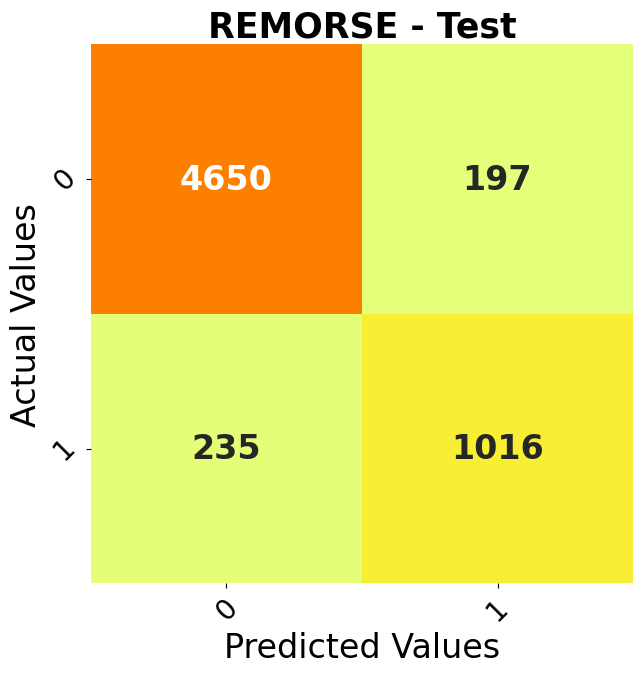

In [ ]:
plot_curves(train_label_ids,train_df[f'{col}_prob'],col,'train')
plot_curves(val_label_ids,val_df[f'{col}_prob'],col,'val')
plot_curves(test_label_ids,test_df[f'{col}_prob'],col,'test')

final_threshold = 0.64
func(final_threshold=final_threshold,probabilities=test_df[f'{col}_prob'],label_ids=test_df['label'],col=col,set_name="Test")

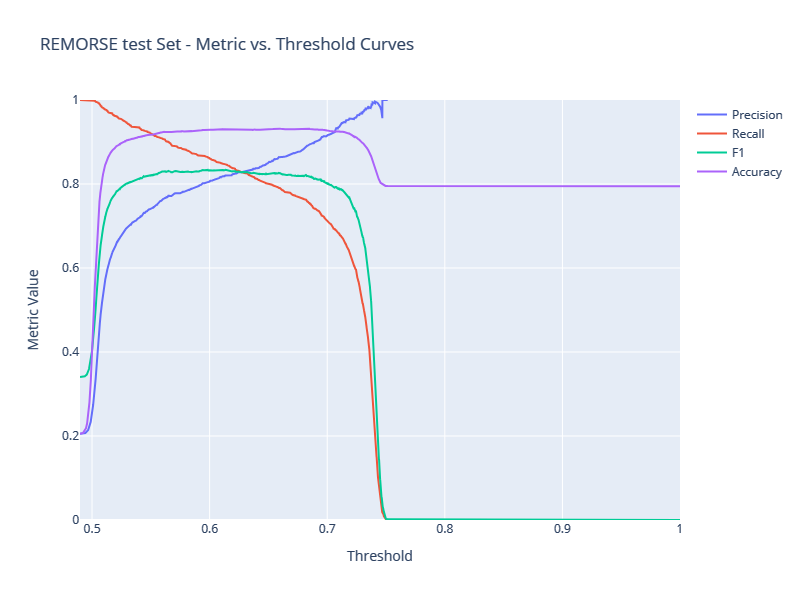

In [ ]:
plot_curves(train_label_ids,train_df[f'{col}_prob'],col,'train')

# Optuna

In [ ]:
import optuna
from transformers import Trainer, TrainingArguments
from transformers import DistilBertConfig, DistilBertForSequenceClassification

def objective(trial):
    # Existing hyperparameter suggestions
    learning_rate = trial.suggest_float('learning_rate', 5e-6, 5e-5,log=True)
    # per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 0.01, 0.1)

    # Additional dropout rate suggestions
    seq_classif_dropout = trial.suggest_float('seq_classif_dropout', 0.1, 0.5)
    attention_dropout = trial.suggest_float('attention_dropout', 0.1, 0.5)

    # Load the configuration of DistilBERT with hyperparameters from the trial
    config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                              seq_classif_dropout=seq_classif_dropout,
                                              attention_dropout=attention_dropout,num_labels=1)

    # Now, instantiate the model with this configuration
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

    # Set up training arguments with the trial's hyperparameters
    training_args = TrainingArguments(
        output_dir='./results',num_train_epochs=10,  # Consider making this a hyperparameter
        per_device_train_batch_size=16,per_device_eval_batch_size=64,warmup_steps=1000,
        learning_rate=learning_rate,weight_decay=weight_decay,logging_dir='./logs',
        load_best_model_at_end=True,
        # Other arguments as before
        logging_steps=1000,  # Log metrics every n steps
        evaluation_strategy="steps",eval_steps=1000,save_steps=1000,# save_total_limit=3,
        # learning_rate=2e-5
    )
    # Your code for the trainer setup and model training goes here
    # Make sure to adapt it to use the model and training_args as defined above
    trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=val_dataset,callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],)

    # train the model
    trainer.train()

    # Returning a metric for Optuna to optimize
    # This could be loss, accuracy, F1 score, etc., depending on your evaluation setup
    evaluation_results = trainer.evaluate()
    return evaluation_results["eval_loss"]  # Example: Minimize evaluation loss

# Example of running the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=8)  # Adjust the number of trials based on computational resources

print("Best trial:")
trial_ = study.best_trial

print(f"  Value: {trial_.value}")
print("  Params: ")
for key, value in trial_.params.items():
    print(f"    {key}: {value}")

message_text = f"{col} Optuna finnished"
bot.send_message(chat_id,message_text);

[I 2024-04-08 13:39:46,095] A new study created in memory with name: no-name-ef05c9f0-941a-4699-81c7-2cae62b354db
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)



Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[I 2024-04-08 14:09:11,941] Trial 0 finished with value: 0.015498628839850426 and parameters: {'learning_rate': 7.439214234322978e-06, 'weight_decay': 0.384389254354397, 'seq_classif_dropout': 0.4871229008409451, 'attention_dropout': 0.24280441871048355}. Best is trial 0 with value: 0.015498628839850426.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration`

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[I 2024-04-08 14:27:47,255] Trial 1 finished with value: 0.027265001088380814 and parameters: {'learning_rate': 0.0003437092264886838, 'weight_decay': 0.2699506351514795, 'seq_classif_dropout': 0.31986740825678683, 'attention_dropout': 0.417000475062539}. Best is trial 0 with value: 0.015498628839850426.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration`

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-6000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


[I 2024-04-08 14:50:00,110] Trial 2 finished with value: 0.017771555110812187 and parameters: {'learning_rate': 6.582742162894543e-05, 'weight_decay': 0.20911992232275908, 'seq_classif_dropout': 0.3695840546636221, 'attention_dropout': 0.11607048827812881}. Best is trial 0 with value: 0.015498628839850426.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguratio

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-6000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-7000 already exists and is non-empty. Saving will proceed but saved re

[I 2024-04-08 15:15:51,648] Trial 3 finished with value: 0.016239020973443985 and parameters: {'learning_rate': 2.2282225601253835e-05, 'weight_decay': 0.31243334755479835, 'seq_classif_dropout': 0.12602688358146882, 'attention_dropout': 0.47188854516917855}. Best is trial 0 with value: 0.015498628839850426.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfigurat

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-6000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-7000 already exists and is non-empty. Saving will proceed but saved re

[I 2024-04-08 15:41:43,462] Trial 4 finished with value: 0.017403163015842438 and parameters: {'learning_rate': 4.8339772200020296e-05, 'weight_decay': 0.13853470882678667, 'seq_classif_dropout': 0.3507813602008346, 'attention_dropout': 0.4420787798490833}. Best is trial 0 with value: 0.015498628839850426.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguratio

Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


# Inference

In [ ]:
raise ValueError("This is an error")

## Good Record

Accuracy   Roc_Auc  F1_score  Precision    Recall  Support    TP   FP  \
0  0.973115  0.973546  0.951364   0.929316  0.974484     1646  1604  122   

     TN  FN  
0  4332  42

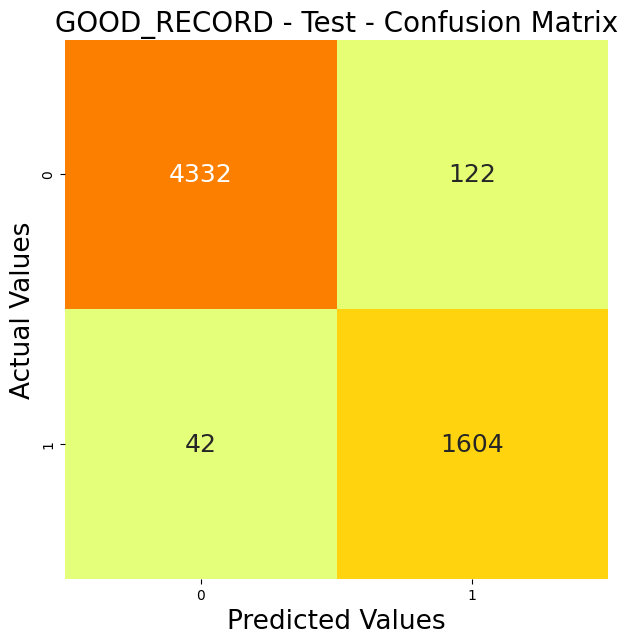

In [ ]:
final_threshold = 0.695

func(final_threshold=final_threshold,probabilities=test_df['GOOD_RECORD_prob'],label_ids=test_df['label'],col=col,set_name="Test")

In [ ]:
plot_curves(test_label_ids,test_df[f'{col}_prob'],col,'test')


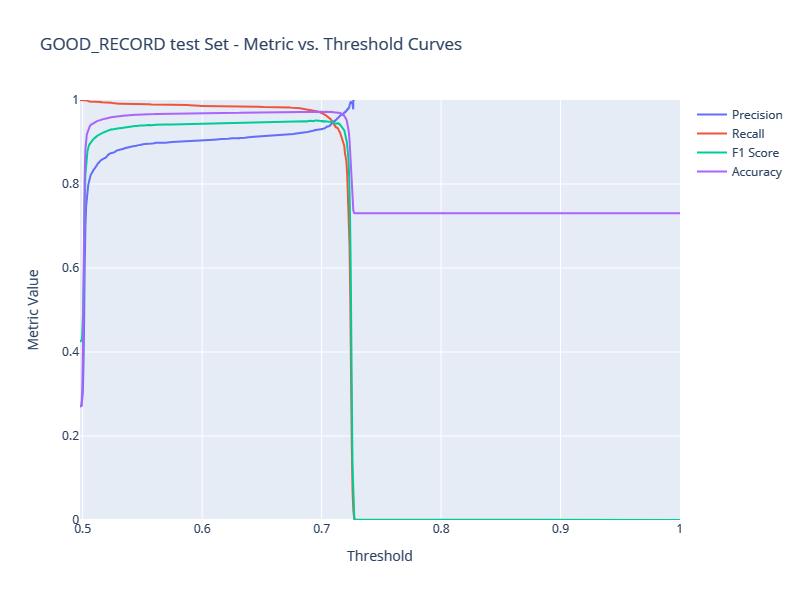

# Requried versions

In [ ]:
# @title
# # prompt: make a list of required versions of all python libs and tools used in this notebook

# # Get the versions of all Python libraries used in the notebook
# !pip freeze

# # Get the versions of all tools used in the notebook
# !which -a python
# !which -a pip
# !which -a conda
# !which -a jupyter
# !which -a git

# # requierments:
# """
# absl-py==1.4.0
# accelerate==0.29.1
# aiohttp==3.9.3
# aiosignal==1.3.1
# alabaster==0.7.16
# albumentations==1.3.1
# alembic==1.13.1
# altair==4.2.2
# annotated-types==0.6.0
# anyio==3.7.1
# appdirs==1.4.4
# argon2-cffi==23.1.0
# argon2-cffi-bindings==21.2.0
# array_record==0.5.1
# arviz==0.15.1
# astropy==5.3.4
# astunparse==1.6.3
# async-timeout==4.0.3
# atpublic==4.1.0
# attrs==23.2.0
# audioread==3.0.1
# autograd==1.6.2
# Babel==2.14.0
# backcall==0.2.0
# beautifulsoup4==4.12.3
# bidict==0.23.1
# bigframes==1.0.0
# bleach==6.1.0
# blinker==1.4
# blis==0.7.11
# blosc2==2.0.0
# bokeh==3.3.4
# bqplot==0.12.43
# branca==0.7.1
# build==1.2.1
# CacheControl==0.14.0
# cachetools==5.3.3
# catalogue==2.0.10
# certifi==2024.2.2
# cffi==1.16.0
# chardet==5.2.0
# charset-normalizer==3.3.2
# chex==0.1.86
# click==8.1.7
# click-plugins==1.1.1
# cligj==0.7.2
# cloudpathlib==0.16.0
# cloudpickle==2.2.1
# cmake==3.27.9
# cmdstanpy==1.2.2
# colorcet==3.1.0
# colorlog==6.8.2
# colorlover==0.3.0
# colour==0.1.5
# community==1.0.0b1
# confection==0.1.4
# cons==0.4.6
# contextlib2==21.6.0
# contourpy==1.2.0
# cryptography==42.0.5
# cufflinks==0.17.3
# cupy-cuda12x==12.2.0
# cvxopt==1.3.2
# cvxpy==1.3.3
# cycler==0.12.1
# cymem==2.0.8
# Cython==3.0.10
# dask==2023.8.1
# datascience==0.17.6
# datasets==2.18.0
# db-dtypes==1.2.0
# dbus-python==1.2.18
# debugpy==1.6.6
# decorator==4.4.2
# defusedxml==0.7.1
# dill==0.3.8
# distributed==2023.8.1
# distro==1.7.0
# dlib==19.24.2
# dm-tree==0.1.8
# docstring_parser==0.16
# docutils==0.18.1
# dopamine-rl==4.0.6
# duckdb==0.9.2
# earthengine-api==0.1.395
# easydict==1.13
# ecos==2.0.13
# editdistance==0.6.2
# eerepr==0.0.4
# en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl#sha256=86cc141f63942d4b2c5fcee06630fd6f904788d2f0ab005cce45aadb8fb73889
# entrypoints==0.4
# et-xmlfile==1.1.0
# etils==1.7.0
# etuples==0.3.9
# exceptiongroup==1.2.0
# fastai==2.7.14
# fastcore==1.5.29
# fastdownload==0.0.7
# fastjsonschema==2.19.1
# fastprogress==1.0.3
# fastrlock==0.8.2
# filelock==3.13.3
# fiona==1.9.6
# firebase-admin==5.3.0
# Flask==2.2.5
# flatbuffers==24.3.25
# flax==0.8.2
# folium==0.14.0
# fonttools==4.50.0
# frozendict==2.4.1
# frozenlist==1.4.1
# fsspec==2023.6.0
# future==0.18.3
# gast==0.5.4
# gcsfs==2023.6.0
# GDAL==3.6.4
# gdown==4.7.3
# geemap==0.32.0
# gensim==4.3.2
# geocoder==1.38.1
# geographiclib==2.0
# geopandas==0.13.2
# geopy==2.3.0
# gin-config==0.5.0
# glob2==0.7
# google==2.0.3
# google-ai-generativelanguage==0.4.0
# google-api-core==2.11.1
# google-api-python-client==2.84.0
# google-auth==2.27.0
# google-auth-httplib2==0.1.1
# google-auth-oauthlib==1.2.0
# google-cloud-aiplatform==1.46.0
# google-cloud-bigquery==3.12.0
# google-cloud-bigquery-connection==1.12.1
# google-cloud-bigquery-storage==2.24.0
# google-cloud-core==2.3.3
# google-cloud-datastore==2.15.2
# google-cloud-firestore==2.11.1
# google-cloud-functions==1.13.3
# google-cloud-iam==2.14.3
# google-cloud-language==2.13.3
# google-cloud-resource-manager==1.12.3
# google-cloud-storage==2.8.0
# google-cloud-translate==3.11.3
# google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz#sha256=1a112d287a907ed66d5640fd33a42cd5b4cf33982a17e6e60b7ed581dd8006b3
# google-crc32c==1.5.0
# google-generativeai==0.3.2
# google-pasta==0.2.0
# google-resumable-media==2.7.0
# googleapis-common-protos==1.63.0
# googledrivedownloader==0.4
# graphviz==0.20.3
# greenlet==3.0.3
# grpc-google-iam-v1==0.13.0
# grpcio==1.62.1
# grpcio-status==1.48.2
# gspread==3.4.2
# gspread-dataframe==3.3.1
# gym==0.25.2
# gym-notices==0.0.8
# h5netcdf==1.3.0
# h5py==3.9.0
# holidays==0.46
# holoviews==1.17.1
# html5lib==1.1
# httpimport==1.3.1
# httplib2==0.22.0
# huggingface-hub==0.20.3
# humanize==4.7.0
# hyperopt==0.2.7
# ibis-framework==8.0.0
# idna==3.6
# imageio==2.31.6
# imageio-ffmpeg==0.4.9
# imagesize==1.4.1
# imbalanced-learn==0.10.1
# imgaug==0.4.0
# importlib_metadata==7.1.0
# importlib_resources==6.4.0
# imutils==0.5.4
# inflect==7.0.0
# iniconfig==2.0.0
# intel-openmp==2023.2.4
# ipyevents==2.0.2
# ipyfilechooser==0.6.0
# ipykernel==5.5.6
# ipyleaflet==0.18.2
# ipython==7.34.0
# ipython-genutils==0.2.0
# ipython-sql==0.5.0
# ipytree==0.2.2
# ipywidgets==7.7.1
# itsdangerous==2.1.2
# jax==0.4.23
# jaxlib @ https://storage.googleapis.com/jax-releases/cuda12/jaxlib-0.4.23+cuda12.cudnn89-cp310-cp310-manylinux2014_x86_64.whl#sha256=8e42000672599e7ec0ea7f551acfcc95dcdd0e22b05a1d1f12f97b56a9fce4a8
# jeepney==0.7.1
# jieba==0.42.1
# Jinja2==3.1.3
# joblib==1.3.2
# jsonpickle==3.0.3
# jsonschema==4.19.2
# jsonschema-specifications==2023.12.1
# jupyter-client==6.1.12
# jupyter-console==6.1.0
# jupyter-server==1.24.0
# jupyter_core==5.7.2
# jupyterlab_pygments==0.3.0
# jupyterlab_widgets==3.0.10
# kaggle==1.5.16
# kagglehub==0.2.2
# keras==2.15.0
# keyring==23.5.0
# kiwisolver==1.4.5
# langcodes==3.3.0
# launchpadlib==1.10.16
# lazr.restfulclient==0.14.4
# lazr.uri==1.0.6
# lazy_loader==0.3
# libclang==18.1.1
# librosa==0.10.1
# lightgbm==4.1.0
# linkify-it-py==2.0.3
# llvmlite==0.41.1
# locket==1.0.0
# logical-unification==0.4.6
# lxml==4.9.4
# Mako==1.3.2
# malloy==2023.1067
# Markdown==3.6
# markdown-it-py==3.0.0
# MarkupSafe==2.1.5
# matplotlib==3.7.1
# matplotlib-inline==0.1.6
# matplotlib-venn==0.11.10
# mdit-py-plugins==0.4.0
# mdurl==0.1.2
# miniKanren==1.0.3
# missingno==0.5.2
# mistune==0.8.4
# mizani==0.9.3
# mkl==2023.2.0
# ml-dtypes==0.2.0
# mlxtend==0.22.0
# more-itertools==10.1.0
# moviepy==1.0.3
# mpmath==1.3.0
# msgpack==1.0.8
# multidict==6.0.5
# multipledispatch==1.0.0
# multiprocess==0.70.16
# multitasking==0.0.11
# murmurhash==1.0.10
# music21==9.1.0
# natsort==8.4.0
# nbclassic==1.0.0
# nbclient==0.10.0
# nbconvert==6.5.4
# nbformat==5.10.3
# nest-asyncio==1.6.0
# networkx==3.2.1
# nibabel==4.0.2
# nltk==3.8.1
# notebook==6.5.5
# notebook_shim==0.2.4
# numba==0.58.1
# numexpr==2.9.0
# numpy==1.25.2
# nvidia-cublas-cu12==12.1.3.1
# nvidia-cuda-cupti-cu12==12.1.105
# nvidia-cuda-nvrtc-cu12==12.1.105
# nvidia-cuda-runtime-cu12==12.1.105
# nvidia-cudnn-cu12==8.9.2.26
# nvidia-cufft-cu12==11.0.2.54
# nvidia-curand-cu12==10.3.2.106
# nvidia-cusolver-cu12==11.4.5.107
# nvidia-cusparse-cu12==12.1.0.106
# nvidia-nccl-cu12==2.19.3
# nvidia-nvjitlink-cu12==12.4.127
# nvidia-nvtx-cu12==12.1.105
# oauth2client==4.1.3
# oauthlib==3.2.2
# opencv-contrib-python==4.8.0.76
# opencv-python==4.8.0.76
# opencv-python-headless==4.9.0.80
# openpyxl==3.1.2
# opt-einsum==3.3.0
# optax==0.2.2
# optuna==3.6.1
# optuna-integration==3.6.0
# orbax-checkpoint==0.4.4
# osqp==0.6.2.post8
# packaging==24.0
# pandas==2.0.3
# pandas-datareader==0.10.0
# pandas-gbq==0.19.2
# pandas-stubs==2.0.3.230814
# pandocfilters==1.5.1
# panel==1.3.8
# param==2.1.0
# parso==0.8.3
# parsy==2.1
# partd==1.4.1
# pathlib==1.0.1
# patsy==0.5.6
# peewee==3.17.1
# pexpect==4.9.0
# pickleshare==0.7.5
# Pillow==9.4.0
# pip-tools==6.13.0
# platformdirs==4.2.0
# plotly==5.15.0
# plotnine==0.12.4
# pluggy==1.4.0
# polars==0.20.2
# pooch==1.8.1
# portpicker==1.5.2
# prefetch-generator==1.0.3
# preshed==3.0.9
# prettytable==3.10.0
# proglog==0.1.10
# progressbar2==4.2.0
# prometheus_client==0.20.0
# promise==2.3
# prompt-toolkit==3.0.43
# prophet==1.1.5
# proto-plus==1.23.0
# protobuf==3.20.3
# psutil==5.9.5
# psycopg2==2.9.9
# ptyprocess==0.7.0
# py-cpuinfo==9.0.0
# py4j==0.10.9.7
# pyarrow==14.0.2
# pyarrow-hotfix==0.6
# pyasn1==0.6.0
# pyasn1_modules==0.4.0
# pycocotools==2.0.7
# pycparser==2.22
# pydantic==2.6.4
# pydantic_core==2.16.3
# pydata-google-auth==1.8.2
# pydot==1.4.2
# pydot-ng==2.0.0
# pydotplus==2.0.2
# PyDrive==1.3.1
# PyDrive2==1.6.3
# pyerfa==2.0.1.1
# pygame==2.5.2
# Pygments==2.16.1
# PyGObject==3.42.1
# PyJWT==2.3.0
# pymc==5.10.4
# pymystem3==0.2.0
# PyOpenGL==3.1.7
# pyOpenSSL==24.1.0
# pyparsing==3.1.2
# pyperclip==1.8.2
# pyproj==3.6.1
# pyproject_hooks==1.0.0
# pyshp==2.3.1
# PySocks==1.7.1
# pyTelegramBotAPI==4.16.1
# pytensor==2.18.6
# pytest==7.4.4
# python-apt @ file:///backend-container/containers/python_apt-0.0.0-cp310-cp310-linux_x86_64.whl#sha256=b209c7165d6061963abe611492f8c91c3bcef4b7a6600f966bab58900c63fefa
# python-box==7.1.1
# python-dateutil==2.8.2
# python-louvain==0.16
# python-slugify==8.0.4
# python-utils==3.8.2
# pytz==2023.4
# pyviz_comms==3.0.2
# PyWavelets==1.6.0
# PyYAML==6.0.1
# pyzmq==23.2.1
# qdldl==0.1.7.post0
# qudida==0.0.4
# ratelim==0.1.6
# referencing==0.34.0
# regex==2023.12.25
# requests==2.31.0
# requests-oauthlib==1.3.1
# requirements-parser==0.9.0
# rich==13.7.1
# rpds-py==0.18.0
# rpy2==3.4.2
# rsa==4.9
# safetensors==0.4.2
# scikit-image==0.19.3
# scikit-learn==1.2.2
# scipy==1.11.4
# scooby==0.9.2
# scs==3.2.4.post1
# seaborn==0.13.1
# SecretStorage==3.3.1
# Send2Trash==1.8.2
# sentencepiece==0.1.99
# shapely==2.0.3
# six==1.16.0
# sklearn-pandas==2.2.0
# smart-open==6.4.0
# sniffio==1.3.1
# snowballstemmer==2.2.0
# sortedcontainers==2.4.0
# soundfile==0.12.1
# soupsieve==2.5
# soxr==0.3.7
# spacy==3.7.4
# spacy-legacy==3.0.12
# spacy-loggers==1.0.5
# Sphinx==5.0.2
# sphinxcontrib-applehelp==1.0.8
# sphinxcontrib-devhelp==1.0.6
# sphinxcontrib-htmlhelp==2.0.5
# sphinxcontrib-jsmath==1.0.1
# sphinxcontrib-qthelp==1.0.7
# sphinxcontrib-serializinghtml==1.1.10
# SQLAlchemy==2.0.29
# sqlglot==20.11.0
# sqlparse==0.4.4
# srsly==2.4.8
# stanio==0.5.0
# statsmodels==0.14.1
# sympy==1.12
# tables==3.8.0
# tabulate==0.9.0
# tbb==2021.12.0
# tblib==3.0.0
# tenacity==8.2.3
# tensorboard==2.15.2
# tensorboard-data-server==0.7.2
# tensorflow @ https://storage.googleapis.com/colab-tf-builds-public-09h6ksrfwbb9g9xv/tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl#sha256=a2ec79931350b378c1ef300ca836b52a55751acb71a433582508a07f0de57c42
# tensorflow-datasets==4.9.4
# tensorflow-estimator==2.15.0
# tensorflow-gcs-config==2.15.0
# tensorflow-hub==0.16.1
# tensorflow-io-gcs-filesystem==0.36.0
# tensorflow-metadata==1.14.0
# tensorflow-probability==0.23.0
# tensorstore==0.1.45
# termcolor==2.4.0
# terminado==0.18.1
# text-unidecode==1.3
# textblob==0.17.1
# tf-slim==1.1.0
# tf_keras==2.15.1
# thinc==8.2.3
# threadpoolctl==3.4.0
# tifffile==2024.2.12
# tinycss2==1.2.1
# tokenizers==0.15.2
# toml==0.10.2
# tomli==2.0.1
# toolz==0.12.1
# torch @ https://download.pytorch.org/whl/cu121/torch-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=1adf430f01ff649c848ac021785e18007b0714fdde68e4e65bd0c640bf3fb8e1
# torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.2.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=23f6236429e2bf676b820e8e7221a1d58aaf908bff2ba2665aa852df71a97961
# torchdata==0.7.1
# torchsummary==1.5.1
# torchtext==0.17.1
# torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.17.1%2Bcu121-cp310-cp310-linux_x86_64.whl#sha256=27af47915f6e762c1d44e58e8088d22ac97445668f9f793524032b2baf4f34bd
# tornado==6.3.3
# tqdm==4.66.2
# traitlets==5.7.1
# traittypes==0.2.1
# transformers==4.38.2
# triton==2.2.0
# tweepy==4.14.0
# typer==0.9.4
# types-pytz==2024.1.0.20240203
# types-setuptools==69.2.0.20240317
# typing_extensions==4.10.0
# tzdata==2024.1
# tzlocal==5.2
# uc-micro-py==1.0.3
# uritemplate==4.1.1
# urllib3==2.0.7
# vega-datasets==0.9.0
# wadllib==1.3.6
# wasabi==1.1.2
# wcwidth==0.2.13
# weasel==0.3.4
# webcolors==1.13
# webencodings==0.5.1
# websocket-client==1.7.0
# Werkzeug==3.0.2
# widgetsnbextension==3.6.6
# wordcloud==1.9.3
# wrapt==1.14.1
# xarray==2023.7.0
# xarray-einstats==0.7.0
# xgboost==2.0.3
# xlrd==2.0.1
# xxhash==3.4.1
# xyzservices==2023.10.1
# yarl==1.9.4
# yellowbrick==1.5
# yfinance==0.2.37
# zict==3.0.0
# zipp==3.18.1
# /usr/local/bin/python
# /usr/local/bin/pip
# /usr/local/bin/jupyter
# /usr/bin/git
# /bin/git"""